# Temporal-Difference (TD) Control

## TD Introduction

- TD is a combination of ideas from Monto-Carlo methods and DP methods
- TD methods learn directly from episodes of raw experience without a model, like MC
- TD methods update estimates based in part on other learned estimates, without waiting for a final outcome (i.e. they bootstrap), like DP
- TD updates a guess towards a guess
- General Update Rule: Q[s,a] += learning_rate * (td_target - Q[s,a]); where as (td_target - Q[s,a]) is called the TD Error
- TD Methods: 
- - Evaluation/Prediction: TD(0), TD(lambda)
- - Control: SARSA, Q-Learning

<img src="td_data/dp_td.png">


# Q-Learning: Off-Policy TD Control

- Q-Learning is an Off-Policy, model-free algorithm based on well-known Bellman Equation
- Estimate Q* for the greedy behavior policy p:
- TD Target for Q-Learning: R[t+1] + discount_factor * max(Q[next_state])

**Bellman Optimality Equation:**
<img src="td_data/bellman_opt.png">

Simple Example: https://github.com/vmayoral/basic_reinforcement_learning/blob/master/tutorial1/README.md

**One-Step Q-Learning - Q(0) Algorithm:**

<img src="td_data/qlearning_algo.png">
    
    

## Create the CliffWalking Environment

Reward is on all transitions -1 except those into the region marked The Cliff.

<img src="td_data/cliff_walking.png">


In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys
import random
from collections import defaultdict

if "../" not in sys.path:
  sys.path.append("../")

In [2]:
import numpy as np
import sys
from gym.envs.toy_text import discrete


UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class CliffWalkingEnv(discrete.DiscreteEnv):

    metadata = {'render.modes': ['human', 'ansi']}

    def _limit_coordinates(self, coord):
        coord[0] = min(coord[0], self.shape[0] - 1)
        coord[0] = max(coord[0], 0)
        coord[1] = min(coord[1], self.shape[1] - 1)
        coord[1] = max(coord[1], 0)
        return coord

    def _calculate_transition_prob(self, current, delta):
        new_position = np.array(current) + np.array(delta)
        new_position = self._limit_coordinates(new_position).astype(int)
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)
        reward = -100.0 if self._cliff[tuple(new_position)] else -1.0
        is_done = self._cliff[tuple(new_position)] or (tuple(new_position) == (3,11))
        return [(1.0, new_state, reward, is_done)]

    def __init__(self):
        self.shape = (4, 12)

        nS = np.prod(self.shape)
        nA = 4

        # Cliff Location
        self._cliff = np.zeros(self.shape, dtype=np.bool)
        self._cliff[3, 1:-1] = True

        # Calculate transition probabilities
        P = {}
        for s in range(nS):
            position = np.unravel_index(s, self.shape)
            P[s] = { a : [] for a in range(nA) }
            P[s][UP] = self._calculate_transition_prob(position, [-1, 0])
            P[s][RIGHT] = self._calculate_transition_prob(position, [0, 1])
            P[s][DOWN] = self._calculate_transition_prob(position, [1, 0])
            P[s][LEFT] = self._calculate_transition_prob(position, [0, -1])

        # We always start in state (3, 0)
        isd = np.zeros(nS)
        isd[np.ravel_multi_index((3,0), self.shape)] = 1.0

        super(CliffWalkingEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human', close=False):
        self._render(mode, close)

    def _render(self, mode='human', close=False):
        if close:
            return

        outfile = StringIO() if mode == 'ansi' else sys.stdout

        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            # print(self.s)
            if self.s == s:
                output = " x "
            elif position == (3,11):
                output = " T "
            elif self._cliff[position]:
                output = " C "
            else:
                output = " o "

            if position[1] == 0:
                output = output.lstrip() 
            if position[1] == self.shape[1] - 1:
                output = output.rstrip() 
                output += "\n"

            outfile.write(output)
        outfile.write("\n")

In [3]:
env = CliffWalkingEnv()

print(env.reset())
env.render()

print(env.step(0))
env.render()

print(env.step(1))
env.render()

print(env.step(1))
env.render()

print(env.step(2))
env.render()

36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

(24, -1.0, False, {'prob': 1.0})
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

(25, -1.0, False, {'prob': 1.0})
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

(26, -1.0, False, {'prob': 1.0})
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

(38, -100.0, True, {'prob': 1.0})
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  x  C  C  C  C  C  C  C  C  T



## Utility Method

In [4]:
import matplotlib
import numpy as np
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])
    
def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

    return fig1, fig2, fig3

## Epsilon-Greedy Policy

In [5]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    
    return policy_fn

## Q-Learning Algorithm

TODO: Convert this algorithm into Object-Oriented

In [6]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # One step in the environment
        # total_reward = 0.0
        for t in itertools.count():
            
            # Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action] #TD_Error
            Q[state][action] += alpha * td_delta
                
            if done:
                break
                
            state = next_state
    
    return Q, stats

In [13]:
#floppy_bird_env = gym.make("FlappyBird-v0")
#floppy_bird_env.reset()

#Q, stats = q_learning(floppy_bird_env, 500)

Q, stats = q_learning(env, 500)


Episode 500/500.

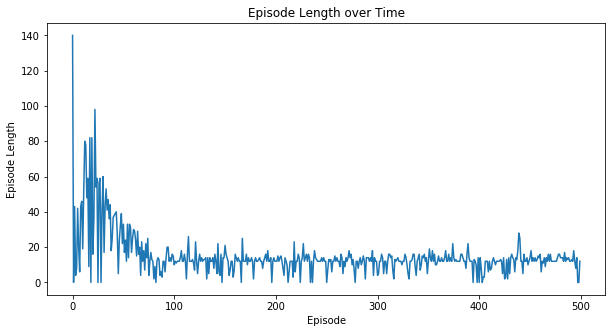

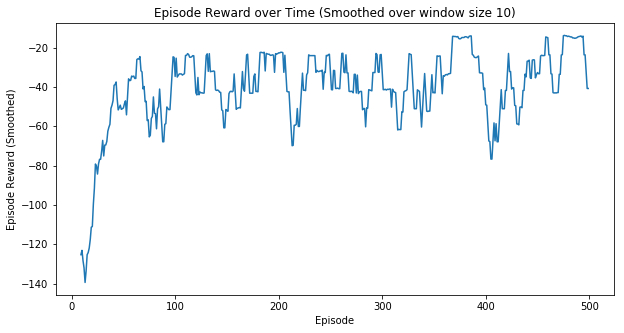

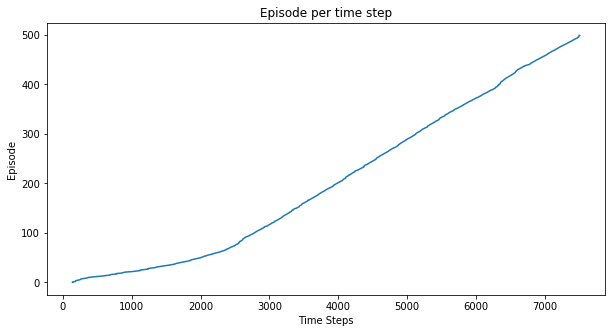

(<matplotlib.figure.Figure at 0x2af929ec518>,
 <matplotlib.figure.Figure at 0x2af91009470>)

In [8]:
plot_episode_stats(stats)

# SARSA: On-Policy TD Control

- State-Action-Reward-State-Action (SARSA) is on-policy algorithm that learns the Q-value based on the action performed by the current policy.
- Estimate Qπ for the current behavior under policy p
- TD Target for SARSA: R[t+1] + discount_factor * Q[next_state][next_action]


**Bellman Expectation Equation for Qπ(s,a):**

<img src="td_data/bellman_exp2.png">

Simple Example: https://github.com/vmayoral/basic_reinforcement_learning/blob/master/tutorial2/README.md


<img src="td_data/sarsa_algo.png">

## Create Windy Gridworld Enviornment

Move from S to G, but consider the crosswind that moves you upward. For example, if you are one cell to the right of the goal, then the action left takes you to the cell just above the goal.

<img src="td_data/windy_grid.png">

Un-discounted, episodic task with constant rewards; reward = –1 until goal reached.

<img src="td_data/windy_grid_sol.png">

In [13]:
from gym.envs.toy_text import discrete

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class WindyGridworldEnv(discrete.DiscreteEnv):

    metadata = {'render.modes': ['human', 'ansi']}

    def _limit_coordinates(self, coord):
        coord[0] = min(coord[0], self.shape[0] - 1)
        coord[0] = max(coord[0], 0)
        coord[1] = min(coord[1], self.shape[1] - 1)
        coord[1] = max(coord[1], 0)
        return coord

    def _calculate_transition_prob(self, current, delta, winds):
        new_position = np.array(current) + np.array(delta) + np.array([-1, 0]) * winds[tuple(current)]
        new_position = self._limit_coordinates(new_position).astype(int)
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)
        is_done = tuple(new_position) == (3, 7)
        return [(1.0, new_state, -1.0, is_done)]

    def __init__(self):
        self.shape = (7, 10)

        nS = np.prod(self.shape)
        nA = 4

        # Wind strength
        winds = np.zeros(self.shape)
        winds[:,[3,4,5,8]] = 1
        winds[:,[6,7]] = 2

        # Calculate transition probabilities
        P = {}
        for s in range(nS):
            position = np.unravel_index(s, self.shape)
            P[s] = { a : [] for a in range(nA) }
            P[s][UP] = self._calculate_transition_prob(position, [-1, 0], winds)
            P[s][RIGHT] = self._calculate_transition_prob(position, [0, 1], winds)
            P[s][DOWN] = self._calculate_transition_prob(position, [1, 0], winds)
            P[s][LEFT] = self._calculate_transition_prob(position, [0, -1], winds)

        # We always start in state (3, 0)
        isd = np.zeros(nS)
        isd[np.ravel_multi_index((3,0), self.shape)] = 1.0

        super(WindyGridworldEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human', close=False):
        self._render(mode, close)

    def _render(self, mode='human', close=False):
        if close:
            return

        outfile = StringIO() if mode == 'ansi' else sys.stdout

        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            # print(self.s)
            if self.s == s:
                output = " x "
            elif position == (3,7):
                output = " T "
            else:
                output = " o "

            if position[1] == 0:
                output = output.lstrip()
            if position[1] == self.shape[1] - 1:
                output = output.rstrip()
                output += "\n"

            outfile.write(output)
        outfile.write("\n")

In [14]:
envWindyGridWorld = WindyGridworldEnv()

print(envWindyGridWorld.reset())
envWindyGridWorld.render()

print(envWindyGridWorld.step(1))
envWindyGridWorld.render()

print(envWindyGridWorld.step(1))
envWindyGridWorld.render()

print(envWindyGridWorld.step(1))
envWindyGridWorld.render()

print(envWindyGridWorld.step(2))
envWindyGridWorld.render()

print(envWindyGridWorld.step(1))
envWindyGridWorld.render()

print(envWindyGridWorld.step(1))
envWindyGridWorld.render()

30
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

(31, -1.0, False, {'prob': 1.0})
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

(32, -1.0, False, {'prob': 1.0})
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

(33, -1.0, False, {'prob': 1.0})
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

(33, -1.0, False, {'prob': 1.0})
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o 

## SARSA Algorithm

TODO: Convert this algorithm into Object-Oriented

In [15]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        # One step in the environment
        for t in itertools.count():
            # Take a step
            next_state, reward, done, _ = env.step(action)
            
            # Pick the next action, poliy driven (can be different)
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
    
            if done:
                break
                
            action = next_action
            state = next_state        
    
    return Q, stats

In [16]:
Q, stats = sarsa(envWindyGridWorld, 200)

Episode 200/200.

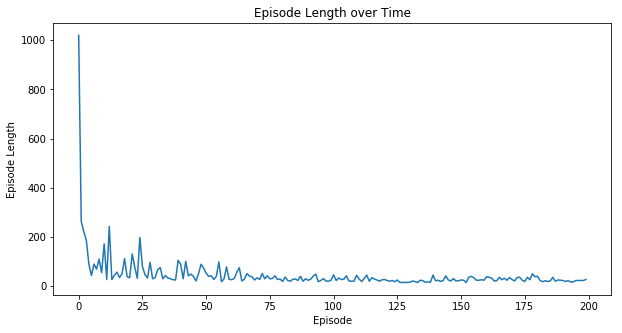

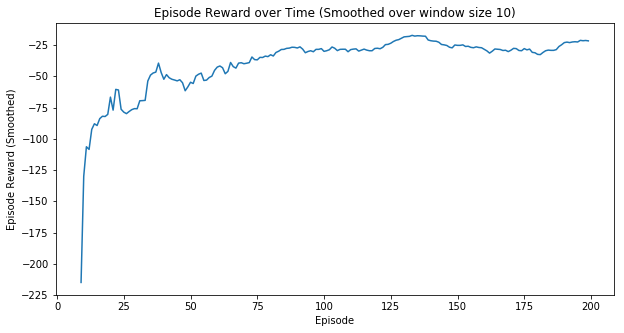

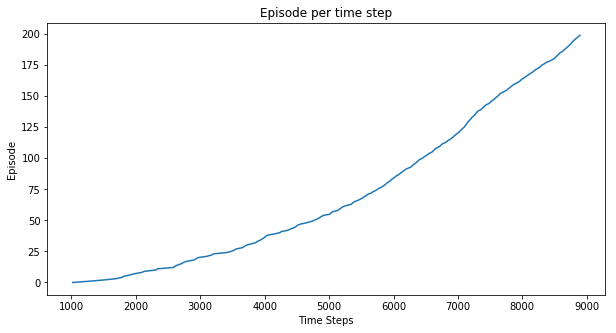

(<matplotlib.figure.Figure at 0x166bba48400>,
 <matplotlib.figure.Figure at 0x166bccba550>)

In [17]:
plot_episode_stats(stats)